# Arithmetic and Bitwise Operations on Images

In this tutorial we will cover the following:

* Arithmetic
    * Addition
    * Weighted Addition (Blending)
    * Subtraction
    * Multiplication
    * Division
* Bitwise
    * Creating Masks
    * AND
    * OR
    * XOR
    * NOT
* Example : Background Removal
* Tips and Best Practices


---

## Standard Imports

In [77]:
import cv2
import numpy as np
from tutorial_utils.utils import *
from matplotlib import pyplot as plt

DATA_DIR = data_dir()

---

# Arithmetic Operations

---

## Image Addition

You can add two images by either using OpenCV's `cv2.add()` function, or the regular `+` operator for numpy addition. However, these two operations may lead to different results.

In general, the addition operation will add each pixel's intensity value from image A with the corresponding pixel's intensity value from image B. However, since intensities (for an 8-bit RGB image) typically lie in the range 0-255, what happens when the sum of two intensities exceeds 255?

This is where the difference between `cv2.add()` and the `+` operation for numpy lies. 
* In `cv2.add()`, the sum is saturated at 255.
    * So 255 + x = 255
* With `+` operation, the values 'roll over', i.e. a modulo operation (sum % 256) is performed
    * sum = sum % 256

---

### Requirements
* Both images should have the same `dtype` and depth (channels), OR, the second image can be just a scalar value
* If both inputs are images, they should have the same HEIGHT x WIDTH dimensions

---

### Example 1

In [78]:
# Difference between the outputs of cv2.add() and numpy addition, for a scalar value

x = np.uint8([[250]])
y = np.uint8([[10]])
z = 10

print("cv2.add() of two arrays gives : ", cv2.add(x,y))
print("Numpy addition of two arrays gives : ", x+y)
print("\n")
print("cv2.add() of array and scalar gives : ", cv2.add(x,z))
print("Numpy addition of array and scalar gives : ", x+z)

cv2.add() of two arrays gives :  [[255]]
Numpy addition of two arrays gives :  [[4]]


cv2.add() of array and scalar gives :  [[255]]
Numpy addition of array and scalar gives :  [[4]]


 ---

 #### Be Careful!

`cv2.add()` expects that both inputs are at least 2D arrays. 

If you pass in a 1D array, like in the example below, it can promote the type from `uint8` to a larger type like `int32` to avoid overflow. This breaks the saturation. 

In [79]:
# Representing scalars as 1-D arrays

x = np.uint8([250]) # or np.array([250], dtype=np.uint8)
y = np.uint8([10]) # or np.array([10], dtype=np.uint8)

print("cv2.add() gives : ", cv2.add(x,y))

cv2.add() gives :  [[260.]
 [  0.]
 [  0.]
 [  0.]]


If you pass in scalars, it automatically infers the `dtype`, so it may not saturate at 255

In [7]:
cv2.add(255, 10)

array([[265.],
       [265.],
       [265.],
       [265.]])

If you explicitly set the `dtype` of the scalars that are passed in, you get an `Overload resolution error`

In [8]:
# x = np.uint8(250)
# y = np.uint8(10)
# cv2.add(x, y)

So the best practice is : Explicitly pass in at least 2D arrays as input, even for scalar values

---

### Example 2

Let's try adding two larger images and see the result

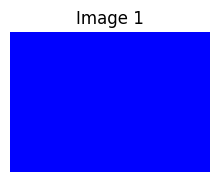

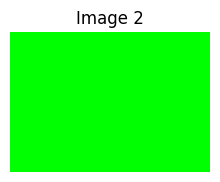

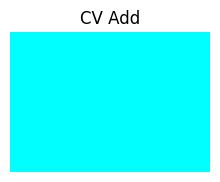

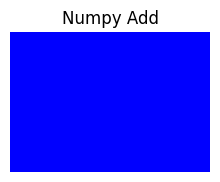

In [9]:
WIDTH = 200
HEIGHT = 140
CHANNELS = 3

# Make an image with (B, G, R) = (255, 1, 0)
img1 = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)
img1[:, :, 0] = 255
img1[:, :, 1] = 1 

# Make an image with (B,G,R) = (0, 255, 0)
img2 = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)
img2[:, :, 1] = 255

cv2_imshow(img1, "Image 1")
cv2_imshow(img2, "Image 2")

img3_cv = cv2.add(img1, img2)
cv2_imshow(img3_cv, "CV Add")

img3_np = img1 + img2
cv2_imshow(img3_np, "Numpy Add")

---

## Image Blending (Weighted Addition)

OpenCV provides the `cv2.addWeighted()` function. This is also image addition, but the final value of each pixel is given by the formula:

$dst(r,c) = \alpha * img1(r,c) + \beta * img2(r,c) + \gamma$

Here, $\beta = 1 - \alpha$

* Like in CV2 addition, the pixel intensities get saturated.
* $\gamma$ is a scalar value that is uniformly added to all pixel intensities of the blended image. Typically we set it to 0, but we can make it larger if we want to drive more pixels towards saturation.

---

### Requirements
* Both images should have the same `dtype` and depth (channels), OR, the second image can be just a scalar value
* If both inputs are images, they should have the same HEIGHT x WIDTH dimensions

---

### Example

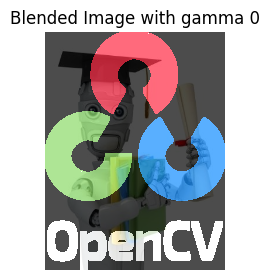

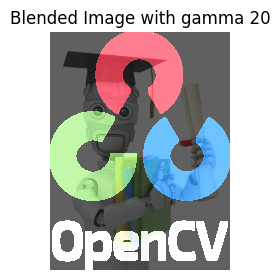

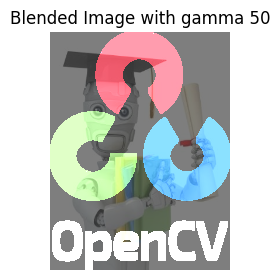

In [10]:
img1 = cv2.imread(DATA_DIR + 'opencv-logo-white.png')
img2 = cv2.imread(DATA_DIR + 'ml.png')

height, width = img1.shape[0], img1.shape[1]
img2 = cv2.resize(img2, (width, height)) # Resize to ensure same dimensions

# Blend images
alpha = 0.7
beta = 1 - alpha

gamma = [0, 20, 50]
for g in gamma:
    output = cv2.addWeighted(img1, alpha, img2, beta, g)
    cv2_imshow(output, "Blended Image with gamma " + str(g))

---

## Image Subtraction

OpenCV provides `cv2.subtract()` to subtract one image from the other. This can be used to find differences between images, or, using ROIs, remove some elements of the image.

This function will saturate the intensity of the resulting image's pixels at 0.

---

### Requirements
* Both images should have the same `dtype` and depth (channels), OR, the second image can be just a scalar value
* If both inputs are images, they should have the same HEIGHT x WIDTH dimensions

---

### Example

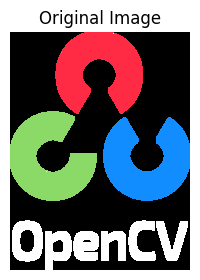

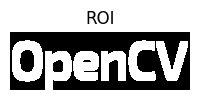

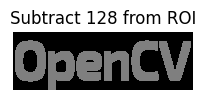

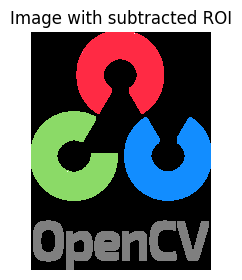

In [11]:
img = cv2.imread(DATA_DIR + 'opencv-logo-white.png')
cv2_imshow(img, "Original Image")

# Make an ROI around the OpenCV text
ROI = img[180:, :, :]
cv2_imshow(ROI, "ROI")

# Subtract 255 from the ROI
ROI_sub = cv2.subtract(ROI, 128)
cv2_imshow(ROI_sub, "Subtract 128 from ROI")

# Replace the ROI
img[180:, :, :] = ROI_sub

cv2_imshow(img, "Image with subtracted ROI")

---

## Image Multiplication

OpenCV provides `cv2.multiply()` that does element-wise multiplication of pixel intensities. 

It automatically handles saturation of pixel intensities at 0 (min) and 255 (max)

Use-Cases:
* Uniformly brightening or darking an image by multiplying all pixel values by a constant amount
    * If you subtracted a constant value from all pixels, the relative intensities between pixels would remain the same. So some pixels would start saturating to 0 earlier
    * If you use multiply instead, the relative intensities between pixels scales uniformly
* Masking : If you multiply an image with a binary mask (all values are either 0 or 1) you get to keep only certain regions of the image
* Scaling Pixel Intensities before feeding images into ML models
* Texture Overlay : This means brightening or darkening specific parts of the image depending on some pattern. For example, overlaying a brick texture on a photo of a wall
    * You can convert both the base image and the texture images from `np.uint8` to `np.float32`.
    * Then, you normalize the texture image by dividing it by 255.0
    * Then, you multiply both images
    * Finally, you convert the result into `np.uint8`

---

### Requirements
* Both images should have the same `dtype` and depth (channels), OR, the second image can be just a scalar value
* If both inputs are images, they should have the same HEIGHT x WIDTH dimensions

---

### Example

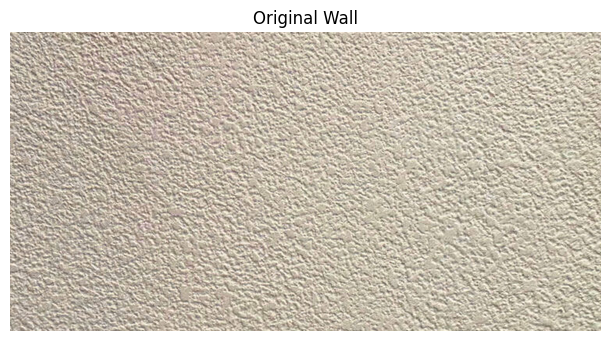

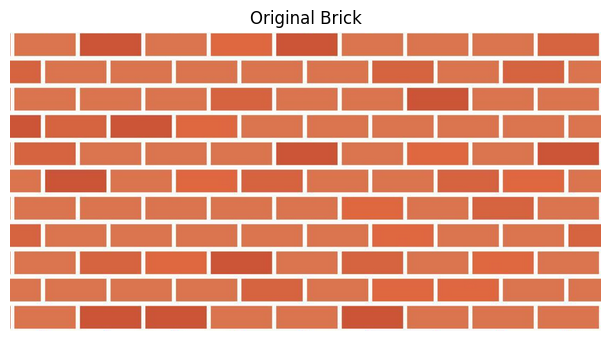

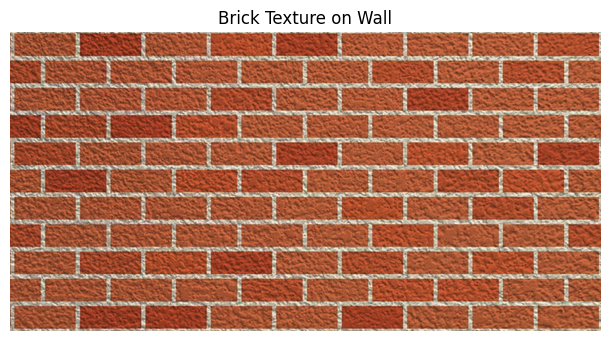

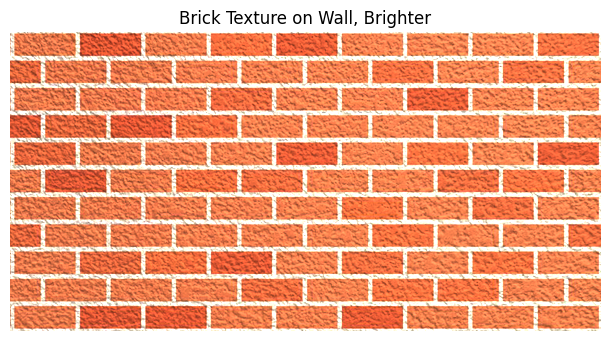

In [12]:
wall = cv2.imread(DATA_DIR + "wall.png")
brick = cv2.imread(DATA_DIR + "brick_texture.png")

wall_float = wall.astype(np.float32)
brick_float = brick.astype(np.float32)

# Texture overlay
mult = cv2.multiply(wall_float, brick_float/255.0).astype(np.uint8)

# Multiply by scalar to uniformly increase brightness
# Note that if you multiply by a float, the dtype of mult is automatically converted to float, so we need to convert it back to uint8
brighter_mult = cv2.multiply(mult, 1.5).astype(np.uint8)

cv2_imshow(wall, "Original Wall")
cv2_imshow(brick, "Original Brick")
cv2_imshow(mult, "Brick Texture on Wall")
cv2_imshow(brighter_mult, "Brick Texture on Wall, Brighter")

---

## Image Division

OpenCV provides `cv2.divide()` that does element-wise division of pixel intensities. 

It automatically handles saturation of pixel intensities at 0 (min) and 255 (max).

Use-Cases:
* Image Normalization : Normalizing lighting or contrast
    * For example, remove uneven illumination in microscopy images
* Creating a Pencil-sketch effect
* Brighten or Darken the whole image uniformly, or in certain areas (similar to multiplication)
* Used in advanced filters for feature extraction

### Requirements
* Both images should have the same `dtype` and depth (channels), OR, the second image can be just a scalar value
* If both inputs are images, they should have the same HEIGHT x WIDTH dimensions

---

### Example 1

In this example we try to normalize the lighting or contrast in a microscopy image with uneven illumination. This is done by dividing the image by a blurred version of itself. This blurred version is a proxy for a mask that is trying to represent darker and lighter areas of the image. By adjusting the blur radius, you will get different results in terms of what features are enhanced and how much the lighting is evened out. 

Note that in this case, each pixel is divided by some value close to itself, so the value could end up being close to 1, which is very dark on a 0-255 scale. Therefore, we need to adjust the `scale` parameter to uniformly scale up the brightness of the image.

Don't focus too much on `blur` - we will cover this in a later module.

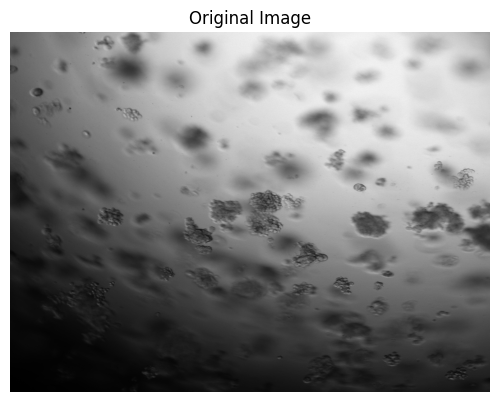

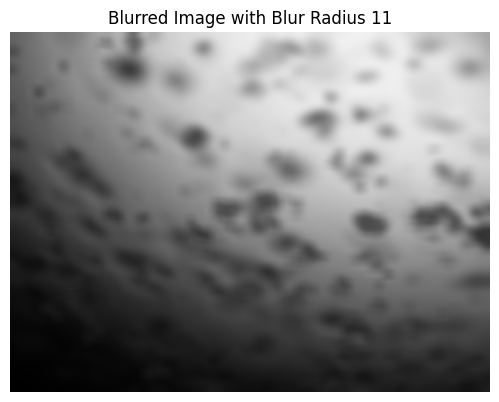

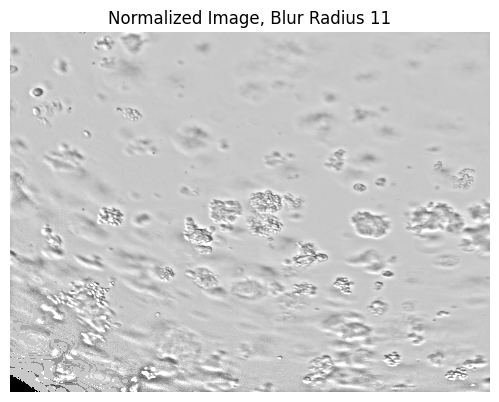

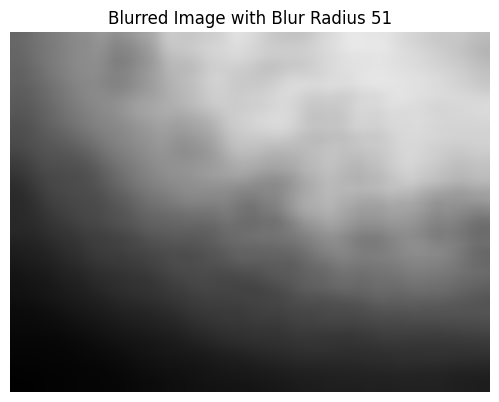

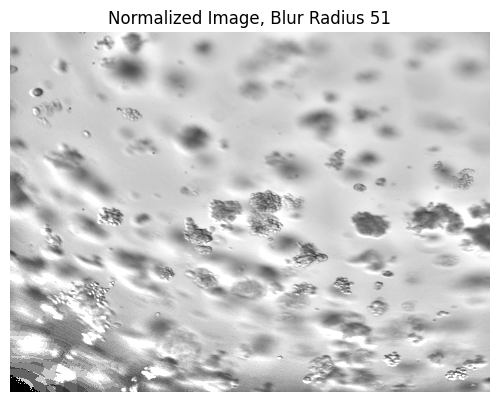

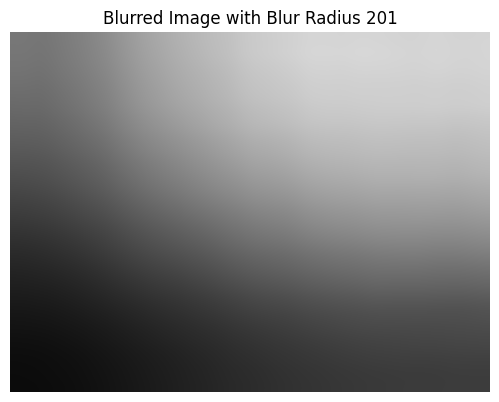

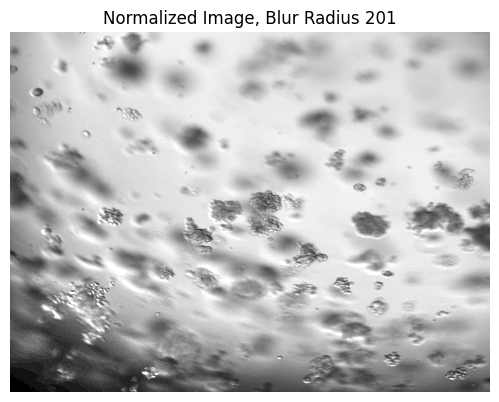

In [13]:
img = cv2.imread(DATA_DIR + "uneven_lighting.jpeg")
img = cv2.resize(img, (480, 360))


cv2_imshow(img, "Original Image")

# Make a blurred version. We will cover cv2.blur() in a later module
blur_radius = [11, 51, 201]
for r in blur_radius:
    blurred = cv2.blur(img, (r, r))
    cv2_imshow(blurred, "Blurred Image with Blur Radius " + str(r))

    # Divide the image with blurred version of itself
    normalized = cv2.divide(img, blurred, scale=200)
    
    cv2_imshow(normalized, "Normalized Image, Blur Radius " + str(r))

---

### Example 2

In this example we will create a pencil-sketch look. This is a popular trick. It is done by dividing the image by its blurred inverse.

Don't focus too much on `cvtColor`, `bitwise_not` or `GaussianBlur` - we will cover these in a later module.

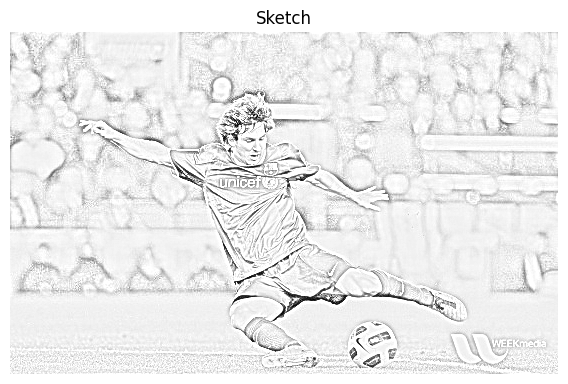

In [14]:
img = cv2.imread(DATA_DIR + "messi5.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
inv = cv2.bitwise_not(gray)
blur = cv2.GaussianBlur(inv, (9,9), 2)

# Divide the images
sketch = cv2.divide(gray, 255-blur, scale=240)

cv2_imshow(sketch, "Sketch")

--- 

# Bitwise Operations

Bitwise operations are applied on the binary representation of each pixel value.

For example, for a `uint8` `a = 150` (binary `10010110`) and `b = 200` (binary `11001000`), the bitwise AND (`&`) would be `128` (binary `10000000`). 

OpenCV provides the following useful operations:
* `bitwise_and`
* `bitwise_or`
* `bitwise_not`
* `bitwise_xor`

Bitwise operations are different from Logical Operations, such as `np.logical_and` that is provided by Numpy. Such operations treat any non-zero value as True, and only an exact zero value as False. OpenCV does not provide functions for logical operations (but you can do such operations with numpy functions if needed, since the images are just numpy arrays).

---

## Creating Masks

A 'Mask' is an **8-bit, single channel** image. 
* If the value of the pixel is Zero, it is treated as False / Block
* If the value of the pixel is greater than Zero, it is treated as True / Pass

And so, a mask can be thought of a filter that provides GO/No-GO decisions on specific regions of whatever image it is applied to.

Conventionally, masks are represented with pixel values being either `0` or `255`. This is so that if you want to use `imshow`, you can visualize the mask better. Using `1` instead of `255` also works, but when visualized with `imshow`, the whole mask would appear black since `1` is close to `0` on a 0-255 scale. 


### Example

In this example, we create a simple circular mask.

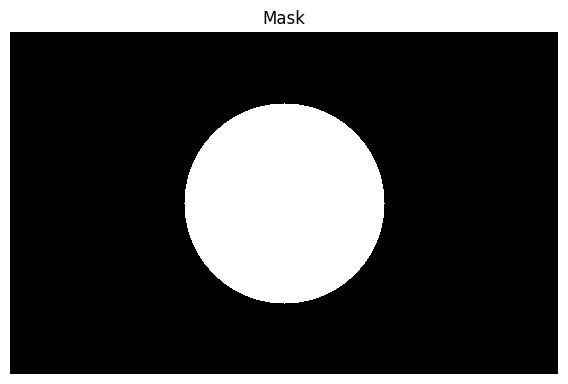

In [16]:
# Load a sample image
img = cv2.imread(DATA_DIR + "messi5.jpg")

# Create a black image
HEIGHT, WIDTH = img.shape[:2]
mask = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)

# Draw a filled white circle in the middle
center = (WIDTH // 2, HEIGHT // 2)
radius = 100
cv2.circle(mask, center, radius, 255, -1)

# Display the mask
cv2_imshow(mask, 'Mask')

---

## Bitwise AND

OpenCV provides the `bitwise_and` operation to operate on two images. This operation takes `mask` as an optional third parameter.


The order of operations is:
* Perform result = img1 & img2.
    * This does bitwise AND on each pixel's value.
* Apply mask on result as a post-processing step.
    * This zeros out the regions of the result, where the mask's value is 0.


If img1 and img2 are the same image, this operation extracts the region of the image that corresponds to WHITE (255) / GO / TRUE region in the mask. 


Note that:
* `bitwise_and(color_img, mask)` is not allowed, since their number of channels are different
    * You must use `bitwise_and(color_img, color_img, mask=mask)` to apply the mask
*  `bitwise_and(gray_img, mask)` is allowed, since their number of channels is same


---

### Requirements
* Both images should have the same `dtype` and depth (channels), OR, the second image can be just a scalar value
* If both inputs are images, they should have the same HEIGHT x WIDTH dimensions
* The MASK must also have the same HEIGHT x WIDTH dimensions as the images
* The MASK must be **8-bit, single-channel**

---

### Example 1

In this example, we apply a mask to select a region of the image.

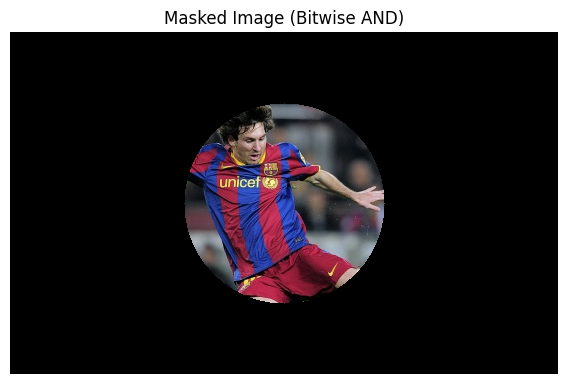

In [27]:
# Load a sample image
img = cv2.imread(DATA_DIR + "messi5.jpg")

# Create a circular mask
HEIGHT, WIDTH = img.shape[:2]
mask = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
center = (WIDTH // 2, HEIGHT // 2)
radius = 100
cv2.circle(mask, center, radius, 255, -1)


# Apply the mask using bitwise AND
masked_img = cv2.bitwise_and(img, img, mask=mask)

# Display the result
cv2_imshow(masked_img, "Masked Image (Bitwise AND)")

---

### Example 2

In this example we simply perform a bitwise AND to two images (without a mask) and see what happens.

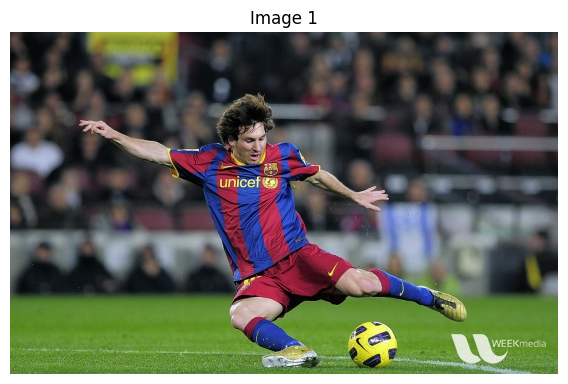

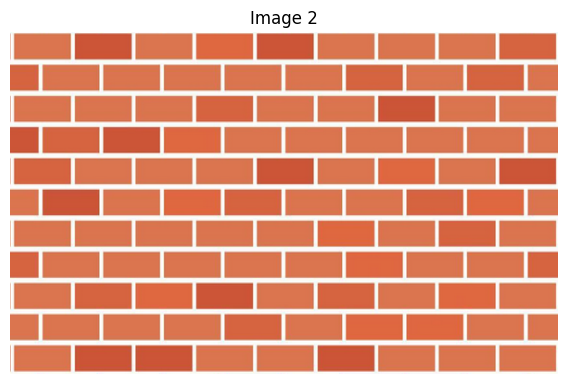

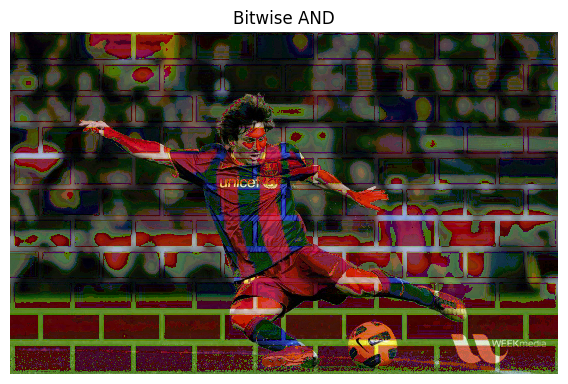

In [40]:
# Load 2 images, ensure they are the same size
img1 = cv2.imread(DATA_DIR + "messi5.jpg")
img2 = cv2.imread(DATA_DIR + "brick_texture.png")
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

cv2_imshow(img1, "Image 1")
cv2_imshow(img2, "Image 2")

and_img = cv2.bitwise_and(img1, img2)
cv2_imshow(and_img, "Bitwise AND")

---

## Bitwise OR

OpenCV provides the `bitwise_or` operation to operate on two images. This operation takes `mask` as an optional third parameter.

This operation combines the pixels of two images. 

The order of operations is:
* Perform result = img1 | img2.
    * This does bitwise OR on each pixel's value.
* Apply mask on result as a post-processing step.
    * This zeros out the regions of the result, where the mask's value is 0.

Note that:
* `bitwise_or(color_img, mask)` is not allowed, since their number of channels are different
    * You must use `bitwise_or(color_img, color_img, mask=mask)` to apply the mask
*  `bitwise_or(gray_img, mask)` is allowed, since their number of channels is same


---

### Requirements
* Both images should have the same `dtype` and depth (channels), OR, the second image can be just a scalar value
* If both inputs are images, they should have the same HEIGHT x WIDTH dimensions
* The MASK must also have the same HEIGHT x WIDTH dimensions as the images
* The MASK must be **8-bit, single-channel**

---

### Example 1

In this example, we use a mask to select a region of the image.  Note how this result doesn't differ from the bitwise_and example. This is because the mask is applied in post-processing (after the AND/OR operation), so it doesn't have an effect on the bitwise operation itself.

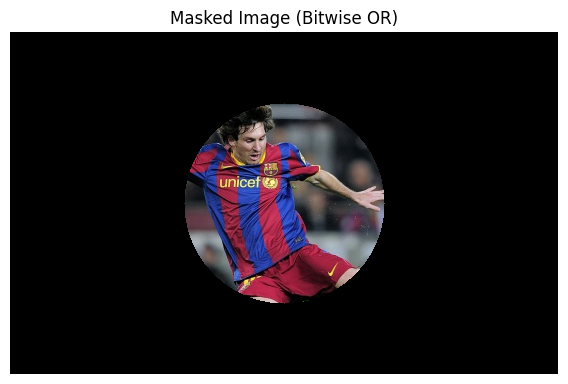

In [41]:
# Load a sample image
img = cv2.imread(DATA_DIR + "messi5.jpg")

# Create a circular mask
HEIGHT, WIDTH = img.shape[:2]
mask = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
center = (WIDTH // 2, HEIGHT // 2)
radius = 100
cv2.circle(mask, center, radius, 255, -1)


# Apply the mask using bitwise OR
masked_img = cv2.bitwise_or(img, img, mask=mask)

# Display the result
cv2_imshow(masked_img, "Masked Image (Bitwise OR)")

---

### Example 2

In this example we perform a bitwise OR operation on two images (without a mask) and see what happens.

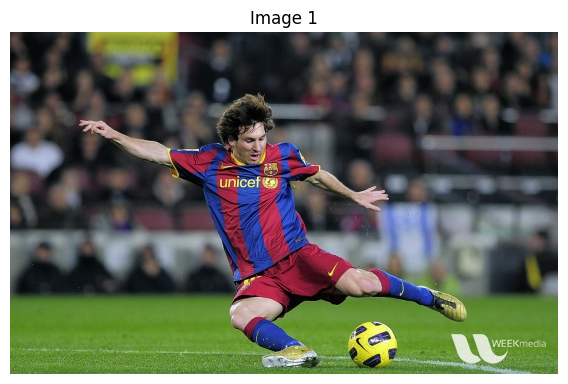

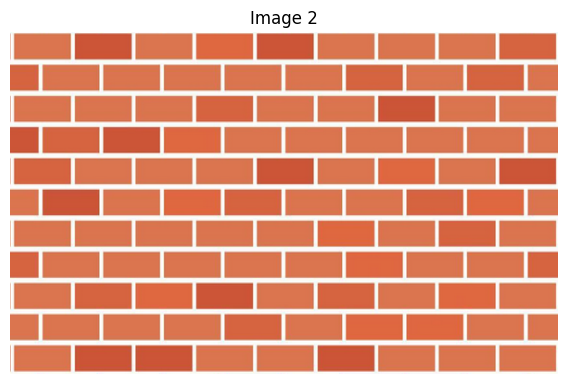

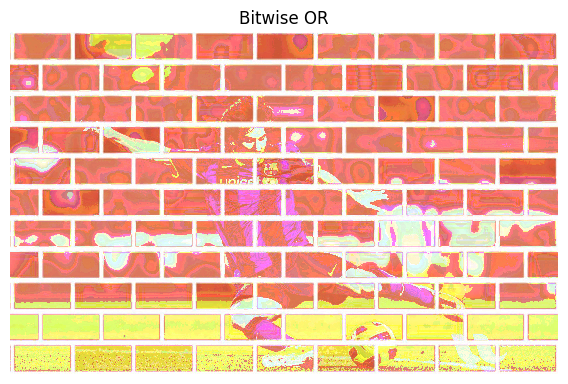

In [42]:
# Load 2 images, ensure they are the same size
img1 = cv2.imread(DATA_DIR + "messi5.jpg")
img2 = cv2.imread(DATA_DIR + "brick_texture.png")
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

cv2_imshow(img1, "Image 1")
cv2_imshow(img2, "Image 2")

or_img = cv2.bitwise_or(img1, img2)
cv2_imshow(or_img, "Bitwise OR")

---

## Bitwise XOR

OpenCV provides the `bitwise_xor` operation to operate on two images. This operation takes `mask` as an optional third parameter.

This operation can be used to darken/zero-out regions where two images exactly match in pixel values, therefore highlight regions where there is a pixel  value mismatch.

The order of operations is:
* Perform result = img1 ^ img2.
    * This does bitwise XOR on each pixel's value.
* Apply mask on result as a post-processing step.
    * This zeros out the regions of the result, where the mask's value is 0.

Note that:
* `bitwise_xor(color_img, mask)` is not allowed, since their number of channels are different
    * You must use `bitwise_xor(color_img, color_img, mask=mask)` to apply the mask
*  `bitwise_xor(gray_img, mask)` is allowed, since their number of channels is same


---

### Requirements
* Both images should have the same `dtype` and depth (channels), OR, the second image can be just a scalar value
* If both inputs are images, they should have the same HEIGHT x WIDTH dimensions
* The MASK must also have the same HEIGHT x WIDTH dimensions as the images
* The MASK must be **8-bit, single-channel**

---

We skip the example of applying a mask to a bitwise_xor. Applying a mask to the result of the bitwise operation won't change the outcome of the bitwise operation itself. You can try out `cv2.bitwise_xor(img1, img2, mask)` for yourself.

---

### Example


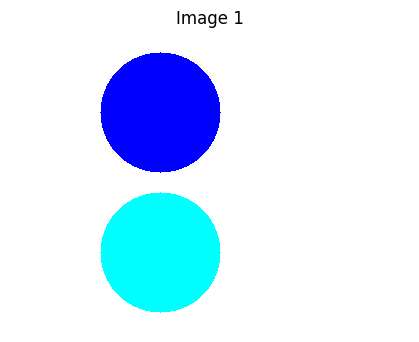

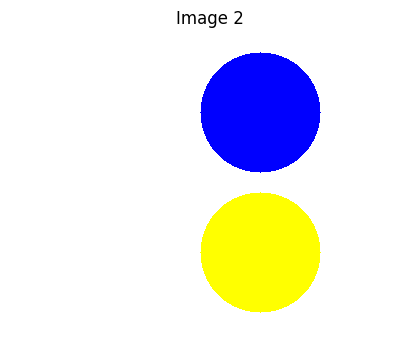

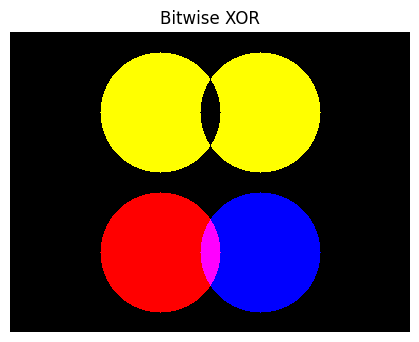

In [61]:
# Create two images of same size
HEIGHT = 300
WIDTH = 400
img1 = np.ones((HEIGHT, WIDTH, 3), dtype=np.uint8) * 255
img2 = np.ones_like(img1) * 255

# Draw circles on img1
cv2.circle(img1, (150,80), 60, (255, 0, 0), -1)
cv2.circle(img1, (150,220), 60, (255, 255, 0), -1)

# Draw circles on img2
cv2.circle(img2, (250,80), 60, (255, 0, 0), -1)
cv2.circle(img2, (250,220), 60, (0, 255, 255), -1)


cv2_imshow(img1, "Image 1")
cv2_imshow(img2, "Image 2")

xor_img = cv2.bitwise_xor(img1, img2)
cv2_imshow(xor_img, "Bitwise XOR")

---

## Bitwise NOT

OpenCV provides the `bitwise_not` operation to operate on a single image. This operation takes `mask` as an optional third parameter.

This operation inverts the colors of an image, therefore creating a photographic negative.

The order of operations is:
* Perform result = !img1.
    * This does bitwise NOT on each pixel's value.
* Apply mask on result as a post-processing step.
    * This zeros out the regions of the result, where the mask's value is 0.

---

### Requirements
* If used, the MASK must have the same HEIGHT x WIDTH dimensions as the image
* The MASK must be **8-bit, single-channel**

---

We skip the example of applying a mask to a bitwise_not. Applying a mask to the result of the bitwise operation won't change the outcome of the bitwise operation itself. You can try out `cv2.bitwise_not(img1, mask)` for yourself.

---

### Example




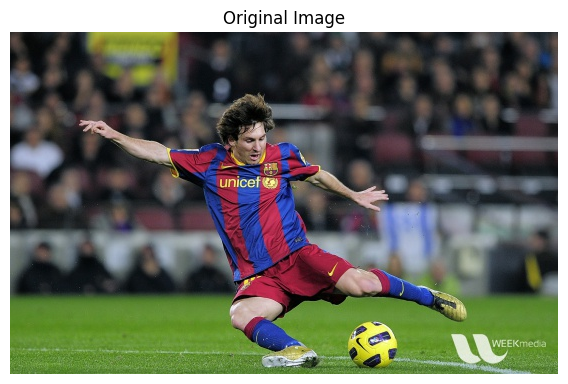

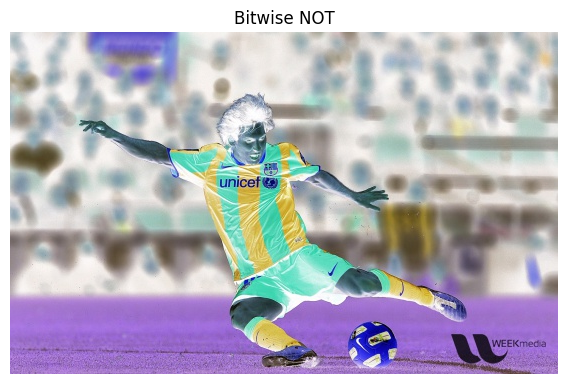

In [63]:
# Load and display original image
img = cv2.imread(DATA_DIR + "messi5.jpg")
cv2_imshow(img, "Original Image")

not_img = cv2.bitwise_not(img)

# Display
cv2_imshow(not_img, "Bitwise NOT")

---

# Example : Background Removal

Suppose we want to place a logo onto an image. The logo is itself an image that has some background. So if we directly copied and pasted the logo into a rectangular ROI on the image, it would copy the background too. This isn't what we want - we only want the logo's foreground to be copied. 

Here is an example of how we can accomplish this.

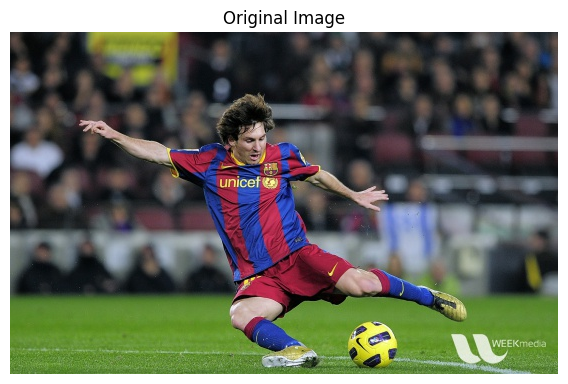

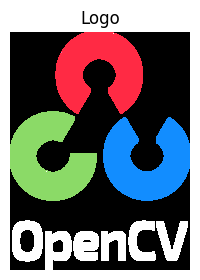

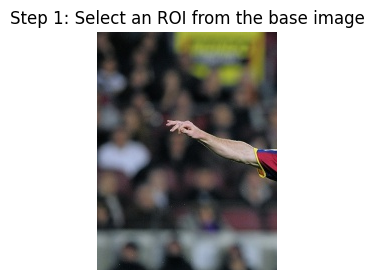

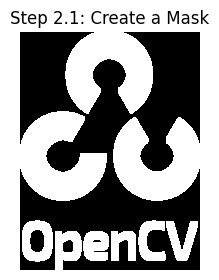

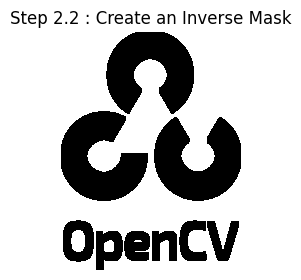

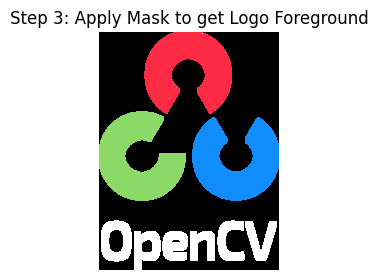

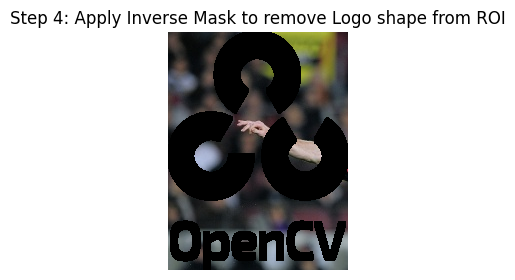

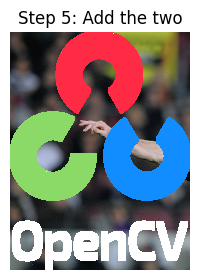

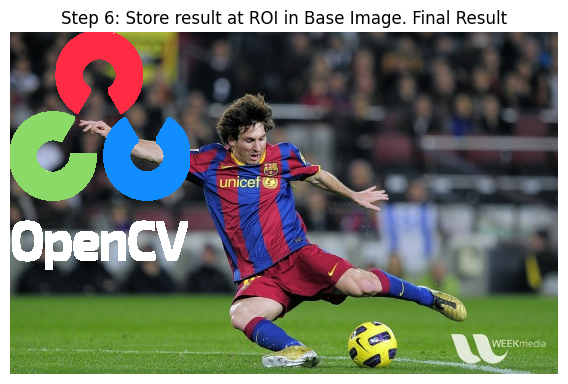

In [76]:
# Load 2 images, ensure they are the same size
img1 = cv2.imread(DATA_DIR + "messi5.jpg")
img2 = cv2.imread(DATA_DIR + "opencv-logo-white.png")

cv2_imshow(img1, "Original Image")
cv2_imshow(img2, "Logo")

# Select an ROI at the top-left corner of the original image.
# This is where we will put our logo
rows, cols, channels = img2.shape 
roi = img1[0:rows, 0:cols] 

cv2_imshow(roi, "Step 1: Select an ROI from the base image")

# Create a Mask and an inverse Mask of the logo
img2gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Mask is 'White' for everything that is part of the logo foreground
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
# Inverse Mask is 'Black' for everything that is part of the logo foreground
mask_inv = cv2.bitwise_not(mask)

cv2_imshow(mask, "Step 2.1: Create a Mask")
cv2_imshow(mask_inv, "Step 2.2 : Create an Inverse Mask")

# Black-out everything that is not a logo foreground, in the logo image
img2_foreground = cv2.bitwise_and(img2, img2, mask=mask)

cv2_imshow(img2_foreground, "Step 3: Apply Mask to get Logo Foreground")

# Black-out everything that is a logo foreground, in the ROI image
roi_no_foreground = cv2.bitwise_and(roi, roi, mask=mask_inv)

cv2_imshow(roi_no_foreground, "Step 4: Apply Inverse Mask to remove Logo shape from ROI")

# Add the two
res = cv2.add(img2_foreground, roi_no_foreground)

cv2_imshow(res, "Step 5: Add the two")

# Store the result in the roi
img1[0:rows, 0:cols] = res

cv2_imshow(img1, "Step 6: Store result at ROI in Base Image. Final Result")

---

# Tips and Best Practices

1. Image Dimensions : Ensure that the images have the same dimensions before performing arithmetic and bitwise operations
2. Data Types : Check the data types of the images being operated on, ensure they are the same. If the data types are not the same, sometimes OpenCV may promote one datatype to another (to avoid overflow) without warning, leading to unexpected outcomes.
3. Masking : Consider using masks to restrict operations to specific regions of interest
4. Saturation : Remember that OpenCV's arithmetic operations are saturated
